In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')


In [3]:
# Reading the dataset
bitstamp = pd.read_csv("/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv")
bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
bitstamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572257 entries, 0 to 4572256
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 279.1 MB


In [5]:
# Converting the Timestamp column from string to datetime
bitstamp['Timestamp'] = [datetime.fromtimestamp(x) for x in bitstamp['Timestamp']]

In [6]:
bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print('Dataset Shape: ',  bitstamp.shape)


Dataset Shape:  (4572257, 8)


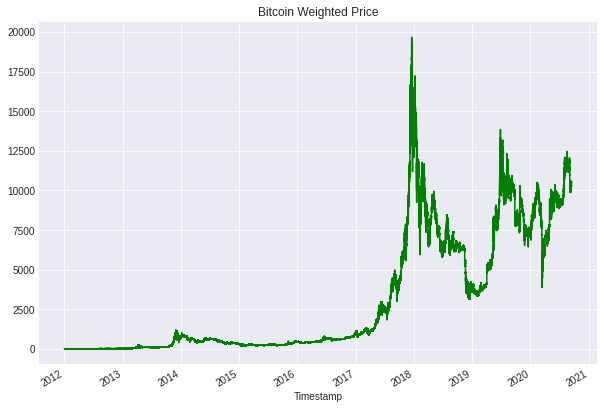

In [8]:
bitstamp.set_index("Timestamp").Weighted_Price.plot(figsize=(10,7), title="Bitcoin Weighted Price", color='green')

## Data PreProcessing

In [9]:
#calculating missing values in the dataset
missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Timestamp,0,0.000000
Open,1241716,27.157616
High,1241716,27.157616
Low,1241716,27.157616
Close,1241716,27.157616
Volume_(BTC),1241716,27.157616
Volume_(Currency),1241716,27.157616
Weighted_Price,1241716,27.157616


In [10]:
#testing missing value methods on a subset

a = bitstamp.set_index('Timestamp')
a = a['2019-11-01 00:10:00':'2019-11-02 00:10:00']

a['ffill'] = a['Weighted_Price'].fillna(method='ffill') # Imputation using ffill/pad
a['bfill'] = a['Weighted_Price'].fillna(method='bfill') # Imputation using bfill/pad
a['interp'] = a['Weighted_Price'].interpolate()         # Imputation using interpolation

a.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ffill,bfill,interp
Timestamp,,,,,,,,,,
2019-11-01 00:10:00,9134.16,9137.31,9131.77,9137.31,0.808039,7380.797039,9134.205412,9134.205412,9134.205412,9134.205412
2019-11-01 00:11:00,9138.71,9141.64,9131.14,9131.14,0.539362,4929.548795,9139.596390,9139.596390,9139.596390,9139.596390
2019-11-01 00:12:00,9133.10,9142.90,9133.02,9142.90,1.963178,17933.986938,9135.180734,9135.180734,9135.180734,9135.180734
2019-11-01 00:13:00,9136.02,9138.59,9132.04,9132.08,0.999556,9133.841693,9137.897366,9137.897366,9137.897366,9137.897366
2019-11-01 00:14:00,9133.77,9139.88,9133.77,9139.88,0.057600,526.263500,9136.533367,9136.533367,9136.533367,9136.533367


#### Imputation using Linear Interpolation method

Time series data has a lot of variations against time. Hence, imputing using backfill and forward fill isn't the best possible solution to address the missing value problem. A more apt alternative would be to use interpolation methods, where the values are filled with incrementing or decrementing values.
Linear interpolation is an imputation technique that assumes a linear relationship between data points and utilises non-missing values from adjacent data points to compute a value for a missing data point.

In [11]:
# function to impute missing values using interpolation
def fill_missing(df):
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()


    print(df.head())
    print("\n")
    print(df.isnull().sum())

In [12]:
fill_missing(bitstamp)

            Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00  4.39  4.39  4.39   4.39      0.555046   
2 2011-12-31 07:54:00  4.39  4.39  4.39   4.39      0.654511   
3 2011-12-31 07:55:00  4.39  4.39  4.39   4.39      0.753977   
4 2011-12-31 07:56:00  4.39  4.39  4.39   4.39      0.853442   

   Volume_(Currency)  Weighted_Price  
0           2.000000            4.39  
1           2.436653            4.39  
2           2.873305            4.39  
3           3.309958            4.39  
4           3.746611            4.39  


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


No Null values in the final output.

## Data Visualisation

In [13]:
#created a copy 
bitstamp_non_indexed = bitstamp.copy()

In [14]:
bitstamp = bitstamp.set_index('Timestamp')
bitstamp.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39


In [15]:
#Resampling data
hourly_data = bitstamp.resample('1H').mean()
hourly_data = hourly_data.reset_index()
hourly_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:00:00,4.39,4.39,4.39,4.39,0.803709,3.528285,4.39
1,2011-12-31 08:00:00,4.39,4.39,4.39,4.39,4.185530,18.374477,4.39
2,2011-12-31 09:00:00,4.39,4.39,4.39,4.39,10.153449,44.573640,4.39
3,2011-12-31 10:00:00,4.39,4.39,4.39,4.39,16.121368,70.772803,4.39
4,2011-12-31 11:00:00,4.39,4.39,4.39,4.39,22.089286,96.971967,4.39


In [16]:
#daily resampling
bitstamp_daily = bitstamp.resample("24H").mean() 
bitstamp_daily.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370
2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576
2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549
2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530
2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680


In [17]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [18]:
bitstamp_daily.reset_index(inplace=True)

trace1 = go.Scatter(
    x = bitstamp_daily['Timestamp'],
    y = bitstamp_daily['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = bitstamp_daily['Timestamp'],
    y = bitstamp_daily['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = bitstamp_daily['Timestamp'],
    y = bitstamp_daily['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(count=60,
                     label='5y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2,trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [19]:
trace1 = go.Scatter(
    x = bitstamp_daily['Timestamp'],
    y = bitstamp_daily['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Currency',
    marker = dict(
            color='#FFBB33')
)

layout = dict(
    title='Currency(USD) Volume traded in Bitcoin with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(count=60,
                     label='5y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [20]:
#BTC Volume vs USD visualization
trace = go.Scattergl(
    y = bitstamp_daily['Volume_(BTC)'].astype(float),
    x = bitstamp_daily['Weighted_Price'].astype(float),
    mode = 'markers',
    marker = dict(
        line = dict(width = 1),
        color='#00FF00'
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Times New Roman, monospace',
            size=18
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Times New Roman, monospace',
            size=18
    )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')


#### Time Series Decomposition & Statistical Tests
We can decompose a time series into trend, seasonal amd remainder components.The seasonal_decompose in statsmodels is used to implements the decomposition.

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
fill_missing(bitstamp_daily)

   Timestamp      Open      High       Low     Close  Volume_(BTC)  \
0 2011-12-31  4.476415  4.478946  4.476415  4.478946     17.940426   
1 2012-01-01  4.765576  4.765576  4.765576  4.765576      6.790640   
2 2012-01-02  5.006549  5.006549  5.006549  5.006549     15.183373   
3 2012-01-03  5.206530  5.206530  5.206530  5.206530      7.917041   
4 2012-01-04  5.202511  5.241699  5.202511  5.241699     13.659736   

   Volume_(Currency)  Weighted_Price  
0          79.495594        4.477370  
1          32.971105        4.765576  
2          75.932706        5.006549  
3          40.795994        5.206530  
4          72.860096        5.216680  


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


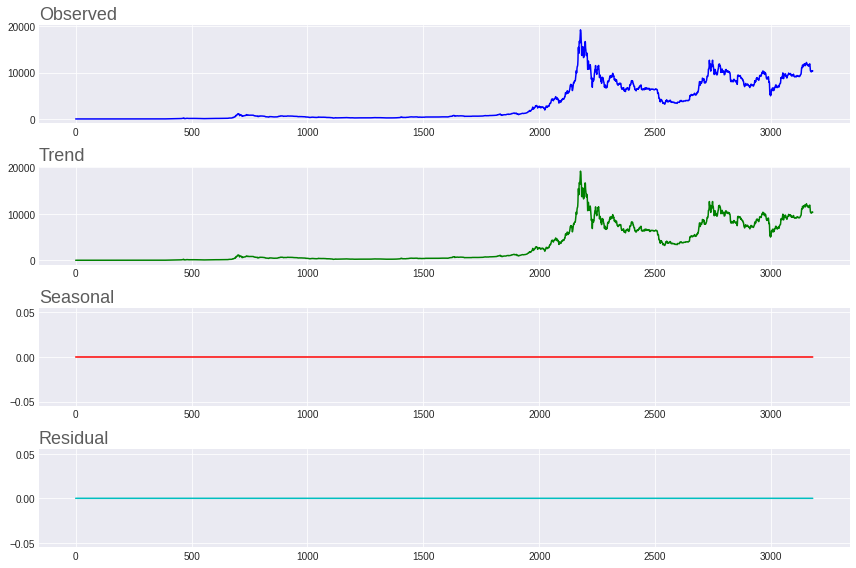

In [23]:
decomposition = sm.tsa.seasonal_decompose(bitstamp_daily.Weighted_Price,period=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ax, fig = plt.subplots(figsize=(12,8), sharex=True)

plt.subplot(411)
plt.plot(bitstamp_daily.Weighted_Price, label='Original',color='b')
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(trend, label='Trend',color='g')
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color='r')
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(residual, label='Residuals',color='c')
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

Post time series decomposition we don't observe any seasonality. Also, there is no constant mean, variance and covariance, hence the series is Non Stationary.

Stastical tests can be performed for checking if the time series is stationary or not. One such test is Dickey-Fuller Test. The DF tests a null hypothesis that a unit root is present in an autoregressive model. If the value is less then <0.05 then the data is stationary.

In [24]:
print("Dicky-Fuller stationarity test: p=%f" % sm.tsa.adfuller(bitstamp_daily["Weighted_Price"])[1])

Dicky-Fuller stationarity test: p=0.648197


#### Rolling windows
A rolling mean, or moving average, is a transformation method which helps average out noise from data. It works by simply splitting and aggregating the data into windows according to function, such as mean(), median(), count(), etc. For this dataset, we’ll use a rolling mean for 3, 7 and 30 days.

In [25]:
df = bitstamp_daily.set_index("Timestamp")

In [26]:
df.reset_index(drop=False, inplace=True)

lag_features = ["Open", "High", "Low", "Close","Volume_(BTC)"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Timestamp", drop=False, inplace=True)
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,3070.007835,3063.529743,...,3023.843754,70.836828,118.491226,269.127206,9.811957,9.817411,9.825918,3.522567,4.288554,5.298253
2012-01-01,2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.476415,4.476415,...,4.478946,70.836828,118.491226,269.127206,17.940426,17.940426,17.940426,3.522567,4.288554,5.298253
2012-01-02,2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,4.620996,4.620996,...,4.622261,0.202678,0.202678,0.202678,12.365533,12.365533,12.365533,7.884089,7.884089,7.884089
2012-01-03,2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,4.749513,4.749513,...,4.750357,0.264130,0.264130,0.264130,13.304813,13.304813,13.304813,5.807423,5.807423,5.807423
2012-01-04,2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,4.992885,4.863768,...,4.864400,0.220794,0.313900,0.313900,9.963685,11.957870,11.957870,4.555332,5.453543,5.453543


In [27]:
df["month"] = df.Timestamp.dt.month
df["week"] = df.Timestamp.dt.week
df["day"] = df.Timestamp.dt.day
df["day_of_week"] = df.Timestamp.dt.dayofweek
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30,month,week,day,day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370,3070.007835,3063.529743,...,9.811957,9.817411,9.825918,3.522567,4.288554,5.298253,12,52,31,5
2012-01-01,2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576,4.476415,4.476415,...,17.940426,17.940426,17.940426,3.522567,4.288554,5.298253,1,52,1,6
2012-01-02,2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549,4.620996,4.620996,...,12.365533,12.365533,12.365533,7.884089,7.884089,7.884089,1,1,2,0
2012-01-03,2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530,4.749513,4.749513,...,13.304813,13.304813,13.304813,5.807423,5.807423,5.807423,1,1,3,1
2012-01-04,2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680,4.992885,4.863768,...,9.963685,11.957870,11.957870,4.555332,5.453543,5.453543,1,1,4,2


In [28]:
df.shape

(3181, 42)

## Model Building

In [29]:
df_train = df[df.Timestamp < "2020"]
df_valid = df[df.Timestamp >= "2020"]

print('train shape :', df_train.shape)
print('validation shape :', df_valid.shape)

train shape : (2923, 42)
validation shape : (258, 42)


## ARIMA Model

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

In [30]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 405 kB/s eta 0:00:01     |███████████████████████████████▋| 1.4 MB 405 kB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 6.5 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [31]:
import pmdarima as pm

In [32]:
exogenous_features = ['Open_mean_lag3',
       'Open_mean_lag7', 'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7',
       'Open_std_lag30', 'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30', 'Close_mean_lag3', 'Close_mean_lag7',
       'Close_mean_lag30', 'Close_std_lag3', 'Close_std_lag7',
       'Close_std_lag30', 'Volume_(BTC)_mean_lag3', 'Volume_(BTC)_mean_lag7',
       'Volume_(BTC)_mean_lag30', 'Volume_(BTC)_std_lag3',
       'Volume_(BTC)_std_lag7', 'Volume_(BTC)_std_lag30', 'month', 'week',
       'day', 'day_of_week']

In [33]:
model = pm.auto_arima(df_train.Weighted_Price, exogenous=df_train[exogenous_features], trace=True,
                      error_action="ignore", suppress_warnings=True)
model.fit(df_train.Weighted_Price, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=38878.107, Time=26.65 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40085.697, Time=4.79 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39088.717, Time=15.99 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39256.270, Time=18.83 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40100.132, Time=23.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=38867.881, Time=26.38 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=38903.986, Time=25.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=39045.050, Time=23.19 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=38873.369, Time=8.95 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=38871.981, Time=28.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=39030.913, Time=24.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=38874.077, Time=30.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=38865.939, Time=25.21 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=38902.277, Time=24.15 sec
 ARIMA(

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



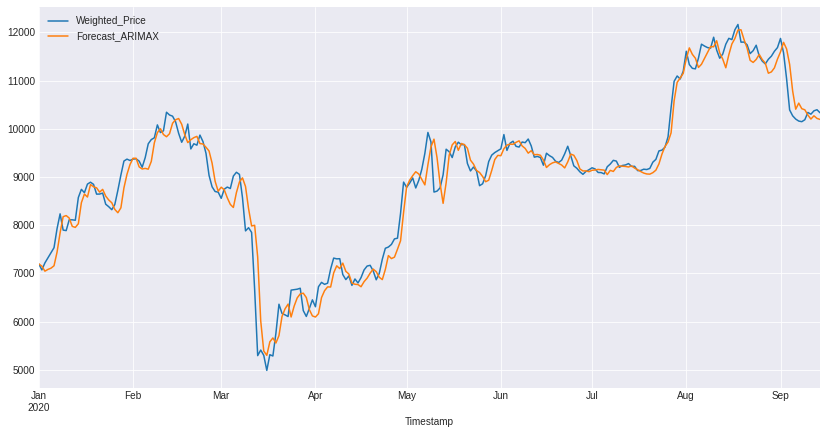

In [34]:
df_valid[["Weighted_Price", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Weighted_Price, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Weighted_Price, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 322.1896817251843

MAE of Auto ARIMAX: 227.00036001821348


## Facebook Prophet


Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality effects.
It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [36]:
from fbprophet import Prophet

In [37]:
# Resampling originial data to day level and forward fill the missing values
daily_data = bitstamp.resample("24H").mean() 
fill_missing(daily_data)

                Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                          
2011-12-31  4.476415  4.478946  4.476415  4.478946     17.940426   
2012-01-01  4.765576  4.765576  4.765576  4.765576      6.790640   
2012-01-02  5.006549  5.006549  5.006549  5.006549     15.183373   
2012-01-03  5.206530  5.206530  5.206530  5.206530      7.917041   
2012-01-04  5.202511  5.241699  5.202511  5.241699     13.659736   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31          79.495594        4.477370  
2012-01-01          32.971105        4.765576  
2012-01-02          75.932706        5.006549  
2012-01-03          40.795994        5.206530  
2012-01-04          72.860096        5.216680  


Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


In [38]:
# Renaming the column names accroding to Prophet's requirements
daily_data_fb = daily_data.reset_index()[['Timestamp','Weighted_Price']].rename({'Timestamp':'ds','Weighted_Price':'y'}, axis=1)
daily_data_fb.head()

,ds,y
0,2011-12-31,4.477370
1,2012-01-01,4.765576
2,2012-01-02,5.006549
3,2012-01-03,5.206530
4,2012-01-04,5.216680


In [39]:
split_date = "2020-01-01"
train_filt = daily_data_fb['ds'] <= split_date
test_filt = daily_data_fb['ds'] > split_date

train_fb = daily_data_fb[train_filt]
test_fb = daily_data_fb[test_filt]

In [40]:
print("train data shape :", train_fb.shape)
print("test data shape :", test_fb.shape)

train data shape : (2924, 2)
test data shape : (257, 2)


In [41]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Timestamp", "Weighted_Price"] + exogenous_features].rename(columns={"Timestamp": "ds", "Weighted_Price": "y"}))

forecast = model_fbp.predict(df_valid[["Timestamp", "Weighted_Price"] + exogenous_features].rename(columns={"Timestamp": "ds"}))
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Close_mean_lag3,Close_mean_lag3_lower,Close_mean_lag3_upper,Close_mean_lag30,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,2676.830342,7069.509097,7698.975493,2676.830342,2676.830342,6237.527006,6237.527006,6237.527006,-19.595029,...,0.278902,0.278902,0.278902,-47.550060,-47.550060,-47.550060,0.0,0.0,0.0,7396.443685
1,2020-01-02,2676.897316,7050.597294,7656.684851,2676.897316,2676.897316,6171.967757,6171.967757,6171.967757,-19.579288,...,-9.227371,-9.227371,-9.227371,-65.132755,-65.132755,-65.132755,0.0,0.0,0.0,7331.042800
2,2020-01-03,2676.964289,6890.600285,7490.007098,2676.964289,2676.964289,6073.072798,6073.072798,6073.072798,-19.545328,...,-9.058655,-9.058655,-9.058655,-82.062307,-82.062307,-82.062307,0.0,0.0,0.0,7195.944373
3,2020-01-04,2677.031263,6964.556121,7552.208327,2677.031263,2677.031263,6081.350401,6081.350401,6081.350401,-19.537282,...,13.567234,13.567234,13.567234,-98.232931,-98.232931,-98.232931,0.0,0.0,0.0,7252.868057
4,2020-01-05,2677.098237,6955.615874,7545.693521,2677.098237,2677.098237,6136.674697,6136.674697,6136.674697,-19.536396,...,1.339751,1.339751,1.339751,-113.552135,-113.552135,-113.552135,0.0,0.0,0.0,7234.236739


 - **yhat** : the predicted forecast
 - **yhat_lower** : the lower border of the prediction
 - **yhat_upper**: the upper border of the prediction

In [42]:
df_valid["Forecast_Prophet"] = forecast.yhat.values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



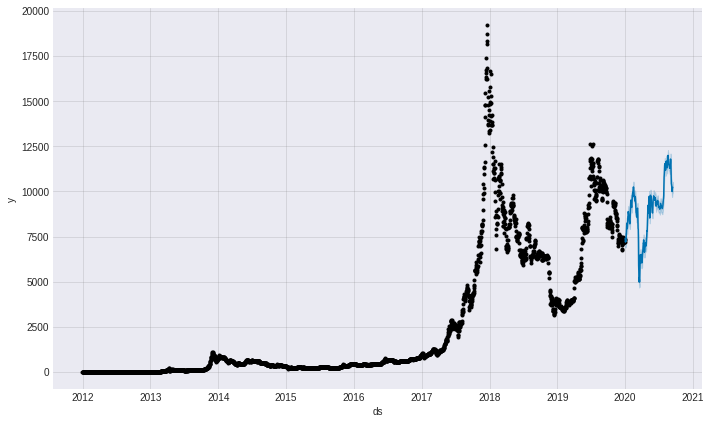

In [43]:
# Plot Our Predictions
fig1 = model_fbp.plot(forecast)

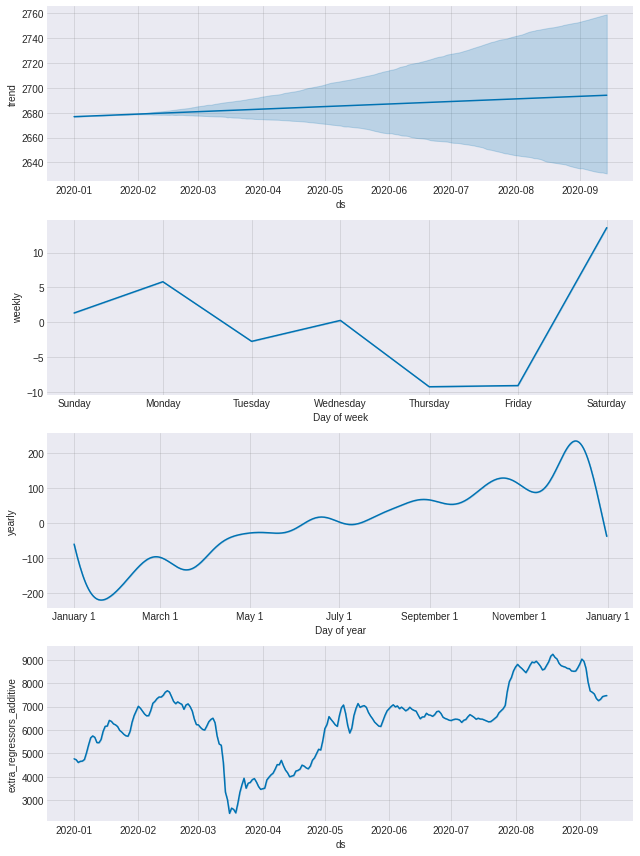

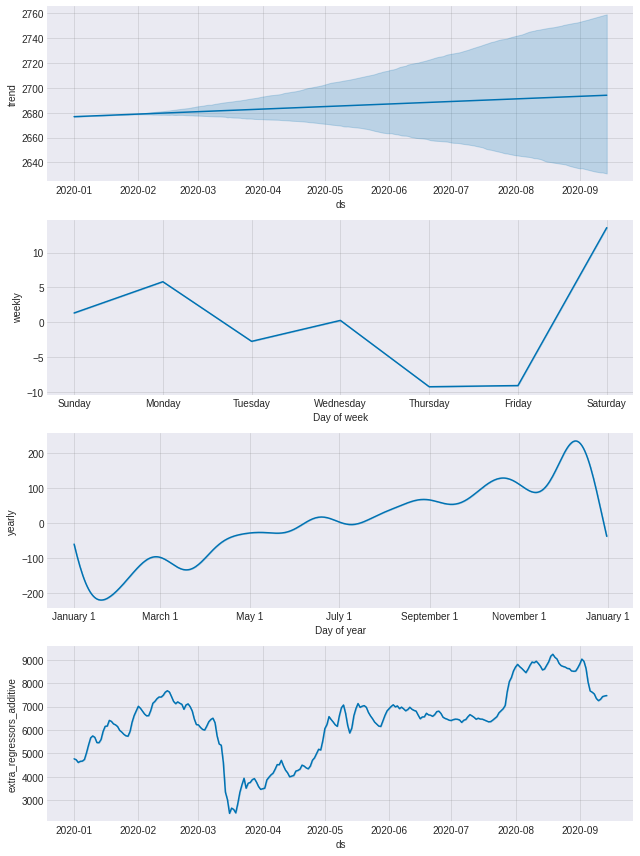

In [44]:
model_fbp.plot_components(forecast)

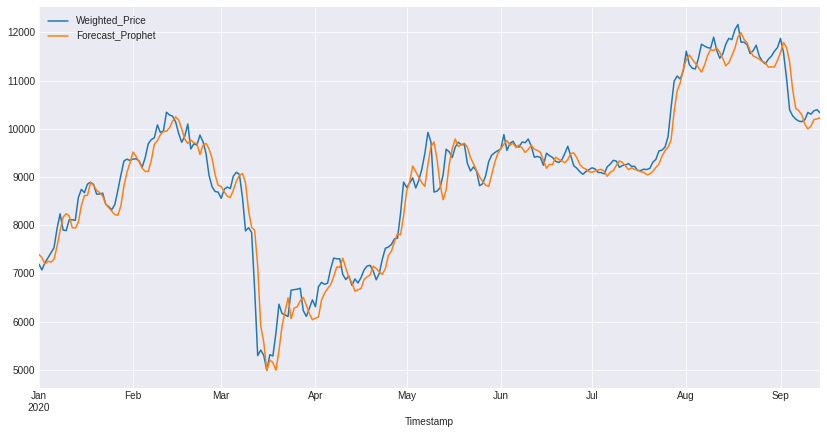

In [45]:
df_valid[["Weighted_Price", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [99]:
test_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet'])
test_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet']))

print(f"Prophet's MAE : {test_mae}")
print(f"Prophet's RMSE : {test_rmse}")

Prophet's MAE : 233.0184261175854
Prophet's RMSE : 327.348083280574


## XGBoost model

In [47]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [48]:
#Train Test Split
X_train, y_train = df_train[exogenous_features], df_train.Weighted_Price
X_test, y_test = df_valid[exogenous_features], df_valid.Weighted_Price

In [49]:
reg = xgb.XGBRegressor()

In [50]:
# Hyper Parameter Optimization
params={
 "learning_rate"    : [0.10,0.20,0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 10, 1)],
 "gamma"            : [0.0, 0.2 , 0.4, 0.6],
 "subsample"        : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.7, 0.9, 1],
 "colsample_bylevel": [0.5, 0.7, 0.9, 1],  
}

In [51]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=20,
                n_jobs=-1,
                cv=5,
                verbose=3,
                )

In [52]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          verbosity=None),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.7, 0.9, 1],
         

In [53]:
print(f"Model Best Parameters : {model.best_params_}")

Model Best Parameters : {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 1, 'learning_rate': 0.2, 'gamma': 0.6, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7}


In [54]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.6, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
model.score(X_test,y_test)

0.9042806626264572

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



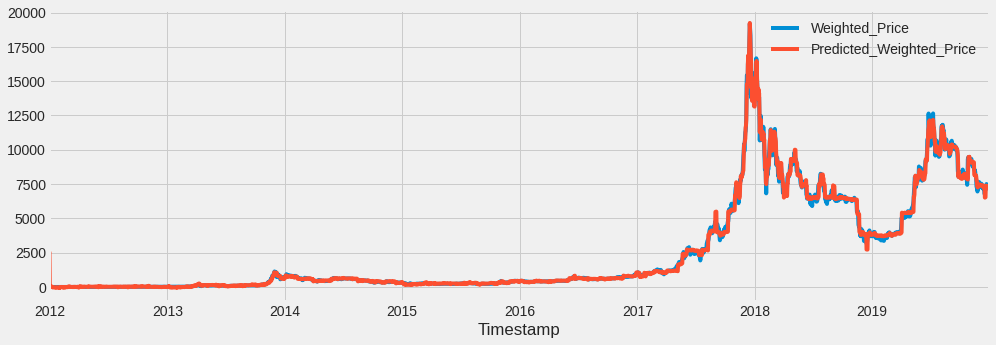

In [56]:
df_train['Predicted_Weighted_Price'] = model.predict(X_train)

df_train[['Weighted_Price','Predicted_Weighted_Price']].plot(figsize=(15, 5))
plt.show()

In [57]:
df_valid['Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([df_train, df_valid], sort=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



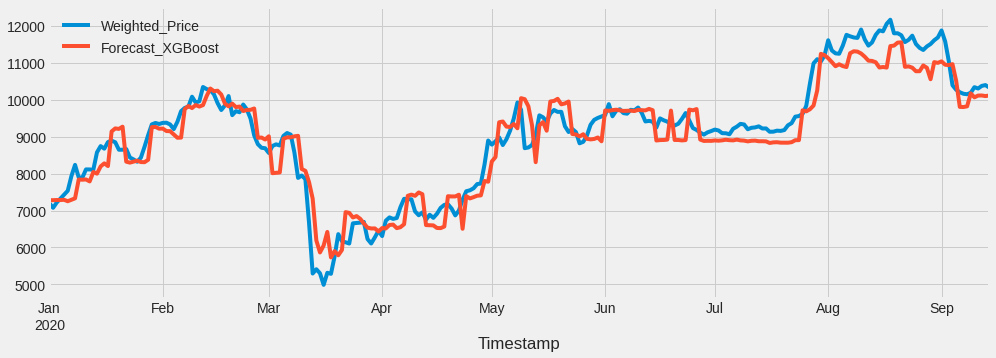

In [58]:
df_valid[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

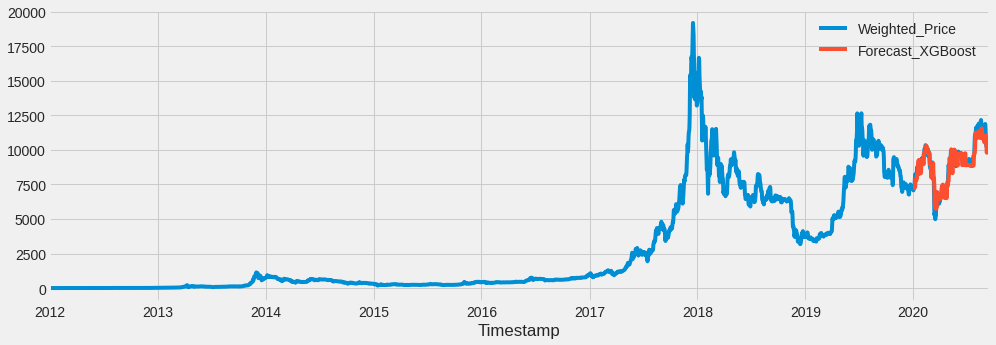

In [59]:
overall_data[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

In [60]:
train_mae = mean_absolute_error(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price'])
train_rmse = np.sqrt(mean_squared_error(df_train['Weighted_Price'], df_train['Predicted_Weighted_Price']))

print(f"train MAE : {train_mae}")
print(f"train RMSE : {train_rmse}")

train MAE : 98.33401369443165
train RMSE : 191.17002897491432


In [61]:
test_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost']))

print(f"test MAE : {test_mae}")
print(f"test RMSE : {test_rmse}")

test MAE : 386.8104183740535
test RMSE : 482.2268967243938


## LSTM

Long Short Term Memory networks are a special kind of RNN, capable of learning long-term dependencies.
LSTMs are explicitly designed to avoid the long-term dependency problem. 
Also, they don't suffer from problems like vanishing/exploding gradient descent.

In [62]:
price_series = bitstamp_daily.reset_index().Weighted_Price.values
price_series

array([4.47737025e+00, 4.76557639e+00, 5.00654859e+00, ...,
       1.03731430e+04, 1.03957982e+04, 1.03324294e+04])

In [63]:
price_series.shape

(3181,)

In [64]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
price_series_scaled = scaler.fit_transform(price_series.reshape(-1,1))

In [65]:
price_series_scaled, price_series_scaled.shape

(array([[6.08556702e-06],
        [2.11105388e-05],
        [3.36730766e-05],
        ...,
        [5.40552894e-01],
        [5.41733970e-01],
        [5.38430384e-01]]),
 (3181, 1))

In [66]:
train_data, test_data = price_series_scaled[0:2923], price_series_scaled[2923:]

In [67]:
train_data.shape, test_data.shape

((2923, 1), (258, 1))

In [68]:
def windowed_dataset(series, time_step):
    dataX, dataY = [], []
    for i in range(len(series)- time_step-1):
        a = series[i : (i+time_step), 0]
        dataX.append(a)
        dataY.append(series[i+ time_step, 0])
        
    return np.array(dataX), np.array(dataY)

In [69]:
X_train, y_train = windowed_dataset(train_data, time_step=100)
X_test, y_test = windowed_dataset(test_data, time_step=100)

In [70]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2822, 100), (2822,), (157, 100), (157,))

In [71]:
#reshape inputs to be [samples, timesteps, features] which is requred for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape) 
print(X_test.shape)

(2822, 100, 1)
(157, 100, 1)


In [72]:
#Create LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [73]:
# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.5))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.5))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True,))
regressor.add(Dropout(0.5))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.5))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [74]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [75]:
# Fitting the LSTM to the Training set
history = regressor.fit(X_train, y_train, validation_split=0.2, epochs = 100, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/100
71/71 [==============================] - 3s 41ms/step - loss: 0.0066 - val_loss: 0.0099
Epoch 2/100
71/71 [==============================] - 2s 23ms/step - loss: 0.0232 - val_loss: 0.0164
Epoch 3/100
71/71 [==============================] - 2s 24ms/step - loss: 0.0212 - val_loss: 0.0050
Epoch 4/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0136 - val_loss: 0.0590
Epoch 5/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0119 - val_loss: 0.0297
Epoch 6/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 7/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0115 - val_loss: 0.0428
Epoch 8/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0223 - val_loss: 0.0540
Epoch 9/100
71/71 [==============================] - 2s 24ms/step - loss: 0.0200 - val_loss: 0.0315
Epoch 10/100
71/71 [==============================] - 2s 24ms/step - loss: 0.0084 - val_loss: 0.0112

71/71 [==============================] - 2s 21ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 83/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 84/100
71/71 [==============================] - 2s 24ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 85/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 86/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 87/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 88/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 89/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 90/100
71/71 [==============================] - 2s 21ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 91/100
71/71 [==============================] - 2s 24ms/step - loss: 0.0034 - val_loss: 0.0017
Epo

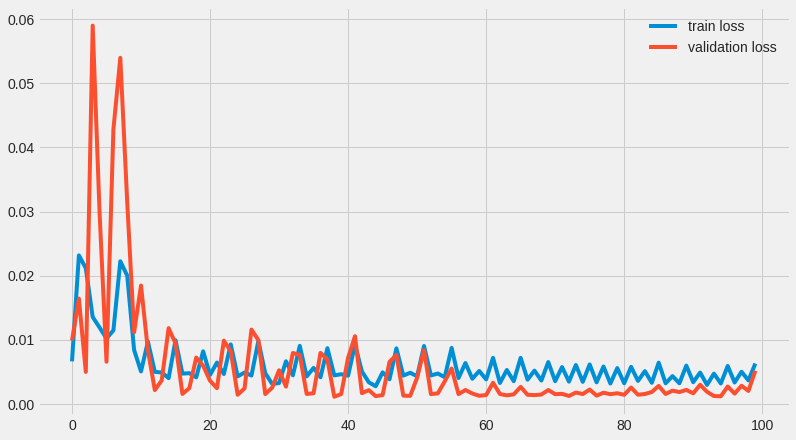

In [76]:
plt.figure(figsize=(12,7))
plt.plot(history.history["loss"], label= "train loss")
plt.plot(history.history["val_loss"], label= "validation loss")
plt.legend()

In [77]:
#prediction
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [78]:
#transformation to original form
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

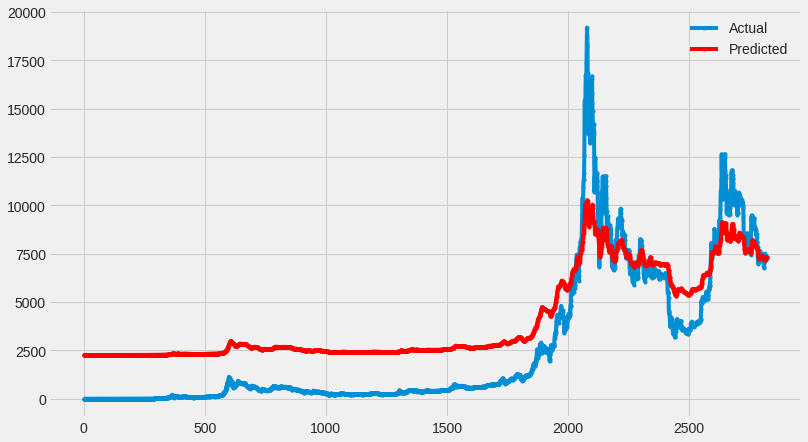

In [79]:
#Prediction on Training data
plt.figure(figsize=(12,7))
plt.plot(y_train_inv.flatten(), marker='.', label="Actual")
plt.plot(train_predict_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()

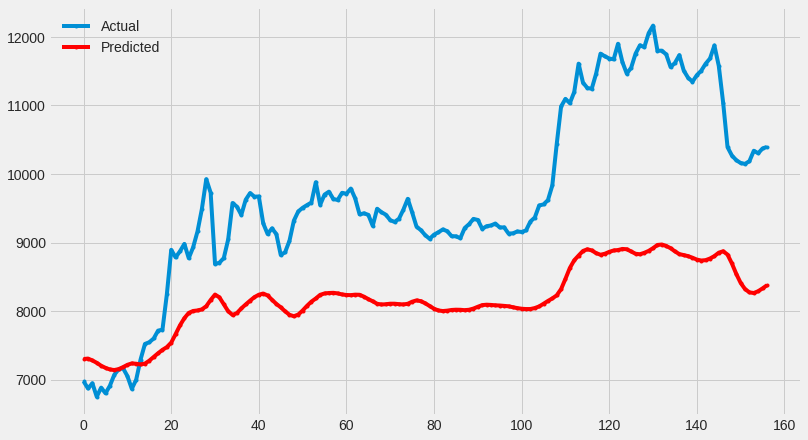

In [80]:
#Prediction on Test data
plt.figure(figsize=(12,7))
plt.plot(y_test_inv.flatten(), marker='.', label="Actual")
plt.plot(test_predict_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()

In [97]:
train_RMSE = np.sqrt(mean_squared_error(y_train, train_predict))
train_MAE = np.sqrt(mean_absolute_error(y_train, train_predict))
LSTM_RMSE = np.sqrt(mean_squared_error(y_test, test_predict))
LSTM_MAE = np.sqrt(mean_absolute_error(y_test, test_predict))


print(f"Train RMSE: {train_RMSE}")
print(f"Train MAE: {train_MAE}")

print(f"Test RMSE: {LSTM_RMSE}")
print(f"Test MAE: {LSTM_MAE}")

Train RMSE: 0.10646585356714015
Train MAE: 0.31343995505940286
Test RMSE: 0.09016122848323625
Test MAE: 0.2819190834604146


## Model Comparison

In [82]:
arimax_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_ARIMAX']))
fbp_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet']))
xgb_rmse = np.sqrt(mean_squared_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost']))

arimax_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_ARIMAX'])
fbp_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_Prophet'])
xgb_mae = mean_absolute_error(df_valid['Weighted_Price'], df_valid['Forecast_XGBoost'])

In [83]:
print("ARIMAX RMSE :", arimax_rmse)
print("FB Prophet RMSE :", fbp_rmse)
print("XGBoost RMSE :", xgb_rmse)
print("LSTM RMSE :", LSTM_RMSE)

print("\nARIMAX MAE :", arimax_mae)
print("FB Prophet MAE :", fbp_mae)
print("XGBoost MAE :", xgb_mae)
print("LSTM MAE :", LSTM_MAE)

ARIMAX RMSE : 322.1896817251843
FB Prophet RMSE : 327.348083280574
XGBoost RMSE : 482.2268967243938
LSTM RMSE : 0.09016122848323625

ARIMAX MAE : 227.00036001821348
FB Prophet MAE : 233.0184261175854
XGBoost MAE : 386.8104183740535
LSTM MAE : 0.2819190834604146


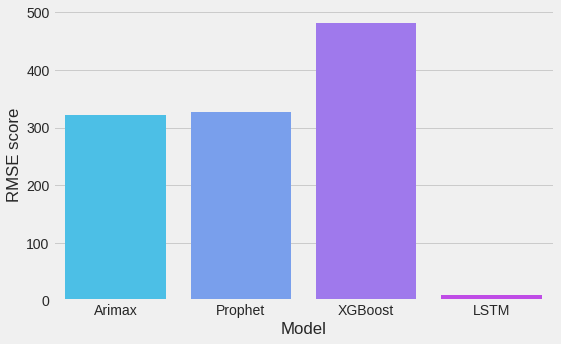

*Note: We have multiplied Rmse score of lstm model by 100 so that it can be visualised


In [102]:
plt.figure(figsize = (8,5))
X = ['Arimax','Prophet','XGBoost','LSTM']
Y = [arimax_rmse,fbp_rmse,xgb_rmse,LSTM_RMSE*100]
ax = sns.barplot(x=X,y=Y,palette='cool')
ax.set(xlabel ='Model',ylabel ='RMSE score')
plt.show()
print('*Note: We have multiplied Rmse score of lstm model by 100 so that it can be visualised')

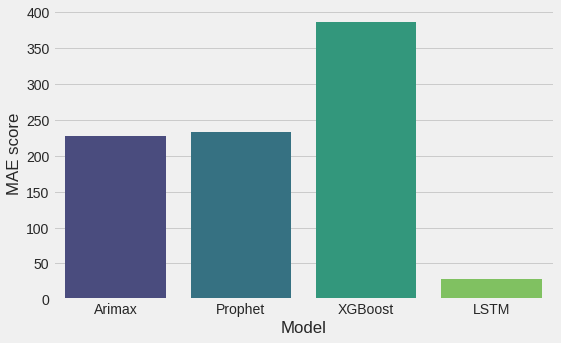

*Note: We have multiplied MAE score of lstm model by 100 so that it can be visualised


In [103]:
plt.figure(figsize = (8,5))
X = ['Arimax','Prophet','XGBoost','LSTM']
Y = [arimax_mae,fbp_mae,xgb_mae,LSTM_MAE*100]
ax = sns.barplot(x=X,y=Y,palette='viridis')
ax.set(xlabel ='Model',ylabel ='MAE score')
plt.show()
print('*Note: We have multiplied MAE score of lstm model by 100 so that it can be visualised')

In [85]:
trace1 = go.Scatter(
    x = df_valid['Timestamp'],
    y = df_valid['Weighted_Price'],
    mode = 'lines',
    name = 'Weighted Price'
)

trace2 = go.Scatter(
    x = df_valid['Timestamp'],
    y = df_valid['Forecast_ARIMAX'],
    mode = 'lines',
    name = 'ARIMA Forecast'
)
trace3 = go.Scatter(
    x = df_valid['Timestamp'],
    y = df_valid['Forecast_Prophet'],
    mode = 'lines',
    name = 'Prophet Forecast'
)
trace4 = go.Scatter(
    x = df_valid['Timestamp'],
    y = df_valid['Forecast_XGBoost'],
    mode = 'lines',
    name = 'XGBoost Forecast'
)
trace5 = go.Scatter(
    x = df_valid['Timestamp'],
    y = df_valid['Weighted_Price'],
    mode = 'lines',
    name = 'Forecast_LSTM'
)


layout = dict(
    title='Model Comparison ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2,trace3,trace4,trace5]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")
